In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as Math
import tensorflow
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv2D, TimeDistributed, LSTM, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import random
import os

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
BASIN = 'NA' # Change to BASIN you want to work for

path1 = os.getcwd()+'/'

#Limiting GPU RAM. Comment these lines if you are not working on a shared GPU.
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth=True
sess = tensorflow.compat.v1.Session(config=config)

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
filePath = path1 + 'WPreanalysisData.csv'
data = pd.read_csv(filePath, index_col=0)

In [4]:
#Scaling the data
total_hurricane_count = len(pd.unique(data['SID']))
print("total hurricane count  ", total_hurricane_count)
gridSize = 41
total = gridSize*gridSize
scalers = {}
cols = []

for i in range(total):
  cols.append('r225_'+str(i))
for i in range(total):
  cols.append('r500_'+str(i))
for i in range(total):
  cols.append('r700_'+str(i))
for i in range(total):
  cols.append('t225_'+str(i))
for i in range(total):
  cols.append('t500_'+str(i))
for i in range(total):
  cols.append('t700_'+str(i))


for i in range(total):
  cols.append('u225_'+str(i))
for i in range(total):
  cols.append('u500_'+str(i))
for i in range(total):
  cols.append('u700_'+str(i))
for i in range(total):
  cols.append('v225_'+str(i))
for i in range(total):
  cols.append('v500_'+str(i))
for i in range(total):
  cols.append('v700_'+str(i))
for i in range(total):
  cols.append('z225_'+str(i))
for i in range(total):
  cols.append('z500_'+str(i))
for i in range(total):
  cols.append('z700_'+str(i))

for col in cols:
    scaler = MinMaxScaler((-1,1))
    scaler.fit(data[[col]])
    data[[col]] = scaler.transform(data[[col]])

cols.append('cateogry')


total hurricane count   2862


In [6]:
data_pad = []

for key in np.unique(data['SID']):
    data_pad += [data[ data.loc[:, 'SID'] == key].loc[:, cols].values]

In [7]:
# Extracting features indexes and adjusting them as per used features, to index in data_pad.

offset = 4  #As SID, ISO_TIME, LAt, LON not used.


r225fIndex = data.columns.get_loc('r225_0')-offset
r225lIndex = data.columns.get_loc('r225_1680')-offset 
t225fIndex = data.columns.get_loc('t225_0')-offset
t225lIndex = data.columns.get_loc('t225_1680')-offset 
u225fIndex = data.columns.get_loc('u225_0')-offset
u225lIndex = data.columns.get_loc('u225_1680')-offset 
v225fIndex = data.columns.get_loc('v225_0')-offset
v225lIndex = data.columns.get_loc('v225_1680')-offset 
z225fIndex = data.columns.get_loc('z225_0')-offset
z225lIndex = data.columns.get_loc('z225_1680')-offset


r500fIndex = data.columns.get_loc('r500_0')-offset
r500lIndex = data.columns.get_loc('r500_1680')-offset
t500fIndex = data.columns.get_loc('t500_0')-offset
t500lIndex = data.columns.get_loc('t500_1680')-offset
u500fIndex = data.columns.get_loc('u500_0')-offset
u500lIndex = data.columns.get_loc('u500_1680')-offset
v500fIndex = data.columns.get_loc('v500_0')-offset
v500lIndex = data.columns.get_loc('v500_1680')-offset
z500fIndex = data.columns.get_loc('z500_0')-offset
z500lIndex = data.columns.get_loc('z500_1680')-offset


r700fIndex = data.columns.get_loc('r700_0')-offset
r700lIndex = data.columns.get_loc('r700_1680')-offset
t700fIndex = data.columns.get_loc('t700_0')-offset
t700lIndex = data.columns.get_loc('t700_1680')-offset 
u700fIndex = data.columns.get_loc('u700_0')-offset
u700lIndex = data.columns.get_loc('u700_1680')-offset
v700fIndex = data.columns.get_loc('v700_0')-offset
v700lIndex = data.columns.get_loc('v700_1680')-offset 
z700fIndex = data.columns.get_loc('z700_0')-offset 
z700lIndex = data.columns.get_loc('z700_1680')-offset 

cateogryIndex = data.columns.get_loc('cateogry')-offset

gridSize = 41

#Training dataset prepearation.
def load_dataCNN(data_pad, trainPoints):
    X = []
    y = []
    leads = []
    #count  = 0
    for cdata in data_pad:
      #count = count + 1
      yy = cdata[0][cateogryIndex]
      length = len(cdata)
      diff = length - trainPoints +1
      for i in range(diff):
          data2 = []
          cc1 = cdata[i : i + trainPoints]
          leads.append(diff-i)
          for j in range(trainPoints):
              data1 = []
              value = cc1[j]
                
              r225 = np.reshape(value[r225fIndex: r225lIndex+1], (gridSize,gridSize))
              r500 = np.reshape(value[r500fIndex: r500lIndex+1], (gridSize,gridSize))
              r700 = np.reshape(value[r700fIndex: r700lIndex+1], (gridSize,gridSize))

              t225 = np.reshape(value[t225fIndex: t225lIndex+1], (gridSize,gridSize))
              t500 = np.reshape(value[t500fIndex: t500lIndex+1], (gridSize,gridSize))
              t700 = np.reshape(value[t700fIndex: t700lIndex+1], (gridSize,gridSize))
            
              u225 = np.reshape(value[u225fIndex: u225lIndex+1], (gridSize,gridSize))
              u500 = np.reshape(value[u500fIndex: u500lIndex+1], (gridSize,gridSize))
              u700 = np.reshape(value[u700fIndex: u700lIndex+1], (gridSize,gridSize))

              v225 = np.reshape(value[v225fIndex: v225lIndex+1], (gridSize,gridSize))
              v500 = np.reshape(value[v500fIndex: v500lIndex+1], (gridSize,gridSize))
              v700 = np.reshape(value[v700fIndex: v700lIndex+1], (gridSize,gridSize))

              z225 = np.reshape(value[z225fIndex: z225lIndex+1], (gridSize,gridSize))
              z500 = np.reshape(value[z500fIndex: z500lIndex+1], (gridSize,gridSize))
              z700 = np.reshape(value[z700fIndex: z700lIndex+1], (gridSize,gridSize))

                
              data1.append(r225)
              data1.append(r500)
              data1.append(r700)
              data1.append(t225)
              data1.append(t500)
              data1.append(t700)
              data1.append(u225)
              data1.append(u500)
              data1.append(u700)
              data1.append(v225)
              data1.append(v500)
              data1.append(v700)
              data1.append(z225)
              data1.append(z500)
              data1.append(z700)
              data2.append(data1)
          X.append(data2)
          y.append(yy)

    X = np.array(X)
    y = np.array(y)
    leads = np.array(leads)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], X.shape[3],X.shape[4])) 
    return [x_train, y, leads]

def build_model(inputShape):
    noOfPredFeatures=1
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation = 'relu',data_format = 'channels_first'), input_shape=inputShape[1:]))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=48, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.15))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.15))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(Dense(noOfPredFeatures, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def leadTimeWiseScores(leadsTime, actuals, predicts):
    leadsCount = leadsTime[0].max()
    length1 = len(leadsTime)
    accuracy = []
    fprs = []
    recalls = []
    precis = []
    f1scores = []
    conMats = []
    for i in range(length1):
        conMat = [[[0,0],[0,0]]]*leadsCount
        conMat = np.array(conMat)
        leads  = leadsTime[i]
        actual = actuals[i]
        predict = predicts[i]
        
        for j in range(len(leads)):
            lead = leads[j]
            pred = predict[j]
            act = actual[j]
            conMat[lead-1][act][pred] = conMat[lead-1][act][pred] +1
        conMats.append(conMat)
    
    for i in range(leadsCount):
        accuracy = []
        fprs = []
        recalls = []
        precis = []
        f1scores = []
        for j in range(length1):
            confs = conMats[j]
            cfm = confs[i]
            TN = cfm[0,0]
            FP = cfm[0,1]
            FN = cfm[1,0]
            TP = cfm[1,1]
            acc = (TP+TN)/(TP+TN+FP+FN)
            fpr = FP/(FP+TN)
            recal = TP/(TP+FN)
            prec = TP/(TP+FP)
            f1 = (2*prec*recal)/(prec+recal)
            accuracy.append(acc)
            fprs.append(fpr)
            recalls.append(recal)
            precis.append(prec)
            f1scores.append(f1)
        print("LEAD TIME ======= ", i*6 + 24 )
        print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
        print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
        print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
        print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
        print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())           
        

In [8]:
from sklearn.metrics import confusion_matrix

noOfTrain = 3 # T = 3 (12 hours)
print("No of data points used  ",noOfTrain," or ", (noOfTrain-1)*6," hours")
print("===========================================================")
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)
yy = yy.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fprs = []
tprs = []
aucs = []
recalls = []
precis = []
f1scores = []

leadTimes = []
actuals = []
predicts = []
for train_index, test_index in kf.split(cnnData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    leadsTest = leads[test_index]

    model = build_model(cnnData.shape)
    model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)
    predictions = model.evaluate(Xc_test, yc_test)
    accuracy.append(predictions[1])
    ypred = model.predict(Xc_test)
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yc_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    
    leadTimes.append(leadsTest)
    actuals.append(yc_test)
    predicts.append(ypred)
    cfm = confusion_matrix(yc_test, ypred)

    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    recal = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = (2*prec*recal)/(prec+recal)
    
    precis.append(prec)
    fprs.append(fpr)
    recalls.append(recal)
    f1scores.append(f1)
    print("accuracy  ", accuracy)
    print("precis  ", precis)
    print("fprs  ", fprs)
    print("recalls  ", recalls)
    print("f1scores  ", f1scores)

print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())   
print("5 Fold AUC of  model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())

leadTimeWiseScores(leadTimes, actuals, predicts)


No of data points used   3  or  12  hours


W0118 18:38:45.335829 139682794096448 deprecation.py:506] From /home/sandeepk/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0118 18:38:45.993255 139682794096448 deprecation.py:323] From /home/sandeepk/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16027 samples, validate on 4007 samples
Epoch 1/30
16027/16027 [==============================] - 184s 11ms/sample - loss: 0.5381 - acc: 0.7325 - val_loss: 0.4636 - val_acc: 0.7876
Epoch 2/30
16027/16027 [==============================] - 30s 2ms/sample - loss: 0.4741 - acc: 0.7774 - val_loss: 0.4659 - val_acc: 0.7954
Epoch 3/30
16027/16027 [==============================] - 29s 2ms/sample - loss: 0.4365 - acc: 0.7987 - val_loss: 0.4154 - val_acc: 0.8066
Epoch 4/30
16027/16027 [==============================] - 29s 2ms/sample - loss: 0.4136 - acc: 0.8124 - val_loss: 0.4157 - val_acc: 0.8048
Epoch 5/30
16027/16027 [==============================] - 29s 2ms/sample - loss: 0.3922 - acc: 0.8217 - val_loss: 0.3913 - val_acc: 0.8305
Epoch 6/30
16027/16027 [==============================] - 29s 2ms/sample - loss: 0.3639 - acc: 0.8349 - val_loss: 0.3753 - val_acc: 0.8278
Epoch 7/30
16027/16027 [==============================] - 27s 2ms/sample - loss: 0.3437 - acc: 0.8509 - val_loss: 0

In [9]:
from sklearn.metrics import confusion_matrix

noOfTrain = 5 # T = 5 (24 hours)
print("No of data points used  ",noOfTrain," or ", (noOfTrain-1)*6," hours")
print("===========================================================")
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)
yy = yy.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fprs = []
tprs = []
aucs = []
recalls = []
precis = []
f1scores = []

leadTimes = []
actuals = []
predicts = []
for train_index, test_index in kf.split(cnnData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    leadsTest = leads[test_index]

    model = build_model(cnnData.shape)
    model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)
    predictions = model.evaluate(Xc_test, yc_test)
    accuracy.append(predictions[1])
    ypred = model.predict(Xc_test)
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yc_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    
    leadTimes.append(leadsTest)
    actuals.append(yc_test)
    predicts.append(ypred)
    cfm = confusion_matrix(yc_test, ypred)

    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    recal = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = (2*prec*recal)/(prec+recal)
    
    precis.append(prec)
    fprs.append(fpr)
    recalls.append(recal)
    f1scores.append(f1)
    print("accuracy  ", accuracy)
    print("precis  ", precis)
    print("fprs  ", fprs)
    print("recalls  ", recalls)
    print("f1scores  ", f1scores)

print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())   
print("5 Fold AUC of  model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())

leadTimeWiseScores(leadTimes, actuals, predicts)


No of data points used   5  or  24  hours
Train on 11448 samples, validate on 2862 samples
Epoch 1/30
11448/11448 [==============================] - 396s 35ms/sample - loss: 0.5426 - acc: 0.7250 - val_loss: 0.4695 - val_acc: 0.7851
Epoch 2/30
11448/11448 [==============================] - 32s 3ms/sample - loss: 0.4576 - acc: 0.7875 - val_loss: 0.4707 - val_acc: 0.7987
Epoch 3/30
11448/11448 [==============================] - 28s 2ms/sample - loss: 0.4238 - acc: 0.8040 - val_loss: 0.3990 - val_acc: 0.8225
Epoch 4/30
11448/11448 [==============================] - 31s 3ms/sample - loss: 0.4022 - acc: 0.8187 - val_loss: 0.4058 - val_acc: 0.8211
Epoch 5/30
11448/11448 [==============================] - 27s 2ms/sample - loss: 0.3843 - acc: 0.8333 - val_loss: 0.3868 - val_acc: 0.8291
Epoch 6/30
11448/11448 [==============================] - 29s 3ms/sample - loss: 0.3669 - acc: 0.8408 - val_loss: 0.4005 - val_acc: 0.8239
Epoch 7/30
11448/11448 [==============================] - 30s 3ms/sample 

Train on 16027 samples, validate on 4007 samples
Epoch 1/30
16027/16027 [==============================] - 36s 2ms/sample - loss: 0.5433 - acc: 0.7273 - val_loss: 0.4807 - val_acc: 0.7714
Epoch 2/30
16027/16027 [==============================] - 25s 2ms/sample - loss: 0.4797 - acc: 0.7700 - val_loss: 0.4580 - val_acc: 0.7876
Epoch 3/30
16027/16027 [==============================] - 25s 2ms/sample - loss: 0.4575 - acc: 0.7871 - val_loss: 0.4416 - val_acc: 0.8058
Epoch 4/30
16027/16027 [==============================] - 25s 2ms/sample - loss: 0.4292 - acc: 0.8056 - val_loss: 0.4012 - val_acc: 0.8191
Epoch 5/30
16027/16027 [==============================] - 26s 2ms/sample - loss: 0.4096 - acc: 0.8159 - val_loss: 0.3834 - val_acc: 0.8238
Epoch 6/30
16027/16027 [==============================] - 26s 2ms/sample - loss: 0.3858 - acc: 0.8241 - val_loss: 0.3935 - val_acc: 0.8233
Epoch 7/30
16027/16027 [==============================] - 27s 2ms/sample - loss: 0.3652 - acc: 0.8396 - val_loss: 0.3

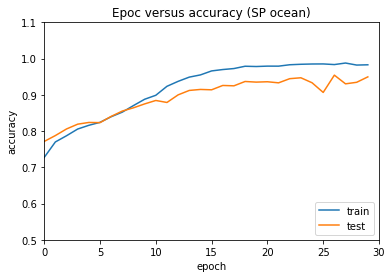

In [11]:
#Generating epoc s train versus test accuracy
noOfTrain = 3 # T = 3 (12 hours)
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)

model = build_model(cnnData.shape)
yy = yy.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(cnnData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]

Xc_test = cnnData[test_index]
yc_test = yy[test_index]

history =  model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,30,0.5,1.1]) 
plt.title('Epoc versus accuracy (SP ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Train on 11448 samples, validate on 2862 samples
Epoch 1/30
11448/11448 [==============================] - 41s 4ms/sample - loss: 0.5672 - acc: 0.7171 - val_loss: 0.5283 - val_acc: 0.7593
Epoch 2/30
11448/11448 [==============================] - 34s 3ms/sample - loss: 0.4582 - acc: 0.7867 - val_loss: 0.4597 - val_acc: 0.7823
Epoch 3/30
11448/11448 [==============================] - 28s 2ms/sample - loss: 0.4209 - acc: 0.8110 - val_loss: 0.4101 - val_acc: 0.8229
Epoch 4/30
11448/11448 [==============================] - 29s 3ms/sample - loss: 0.3941 - acc: 0.8250 - val_loss: 0.3718 - val_acc: 0.8400
Epoch 5/30
11448/11448 [==============================] - 31s 3ms/sample - loss: 0.3655 - acc: 0.8396 - val_loss: 0.3796 - val_acc: 0.8316
Epoch 6/30
11448/11448 [==============================] - 29s 3ms/sample - loss: 0.3442 - acc: 0.8512 - val_loss: 0.3763 - val_acc: 0.8351
Epoch 7/30
11448/11448 [==============================] - 29s 3ms/sample - loss: 0.3216 - acc: 0.8630 - val_loss: 0.3

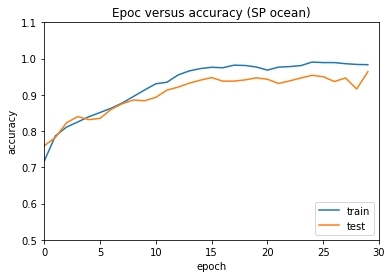

In [12]:
#Generating epoc s train versus test accuracy
noOfTrain = 5 # T = 5 (24 hours)
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)

model = build_model(cnnData.shape)
yy = yy.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(cnnData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]

Xc_test = cnnData[test_index]
yc_test = yy[test_index]

history =  model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,30,0.5,1.1]) 
plt.title('Epoc versus accuracy (SP ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()